In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import gamma, lognorm
import pandas as pd

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, init_params_aniso, NODE_model, NODE_model_aniso
from utils import train_jp, eval_Cauchy_aniso, eval_Cauchy_aniso_vmap, merge_weights_aniso
from utils_diffusion import *

import GPy

In [2]:
n_neurons = 5
with open('params/mice_std_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    std_x = pickle.load(f)
with open('params/mice_mu_x_width_' + str(n_neurons) + '.npy', 'rb') as f:
    mu_x = pickle.load(f)
with open('params/mice_diffusion_params_width_' + str(n_neurons) + '.npy', 'rb') as f:
    params_diff = pickle.load(f)
with open('params/mice_node_m_width_'+str(n_neurons)+'.npy', 'rb') as f:
    params_all = pickle.load(f)
with open('params/mice_node_s_width_'+str(n_neurons)+'.npy', 'rb') as f:
    Sample_params = pickle.load(f)
unravel_params = ravel_pytree(Sample_params[0])[1]
normalization = [3.0,3.0,1.0,1.0]

murine_data = pd.read_csv('data/murine_data.csv')
J = np.max(np.unique(murine_data.ID))

validation_params = Sample_params[-1]
validation_params = ravel_pytree(validation_params)[0]
validation_params = (validation_params-mu_x)/std_x

In [3]:
def plot_offx_offy_equi_pred(ax, l, format, alpha):
    lmby_offx = np.linspace(1,1.265) 
    lmbx_offx = np.sqrt(lmby_offx)
    lmbx_offy = np.linspace(1,1.325) 
    lmby_offy = np.sqrt(lmbx_offy)
    lmbx_equi = np.linspace(1,1.225)
    lmby_equi = lmbx_equi

    l_unscaled = l*std_x+mu_x 
    sample_params = unravel_params(l_unscaled)

    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params, normalization)
    sigx_offx,sigy_offx = eval_Cauchy_aniso_vmap(lmbx_offx,lmby_offx, mymodel) # Offx
    ax[0].plot(lmbx_offx,sigx_offx,format,alpha=alpha)

    sigx_offy,sigy_offy = eval_Cauchy_aniso_vmap(lmbx_offy,lmby_offy, mymodel) # Offy
    ax[1].plot(lmbx_offy,sigx_offy,format,alpha=alpha)

    sigx_equi,sigy_equi = eval_Cauchy_aniso_vmap(lmbx_equi,lmby_equi, mymodel) # Equibi
    ax[2].plot(lmbx_equi,sigx_equi,format,alpha=alpha)
    return sigx_offx*1000, sigx_offy*1000, sigx_equi*1000

#### Conditioning on the "observed" parameters with a Gaussian likelihood

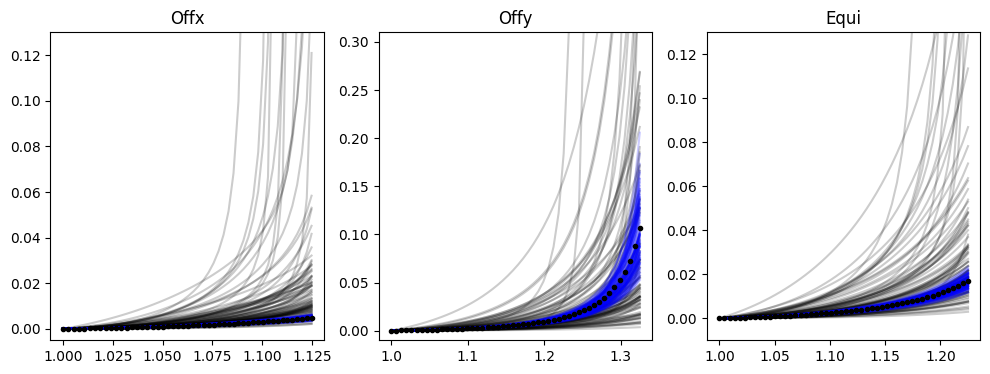

In [4]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)
rng, step_rng = random.split(rng)
n_params = 31
samples = reverse_sde(step_rng, n_params, 100, drift, dispersion, trained_score)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

lmby_offx = np.linspace(1,1.25) 
lmbx_offx = np.sqrt(lmby_offx)
lmbx_offy = np.linspace(1,1.3) 
lmby_offy = np.sqrt(lmbx_offy)
lmbx_equi = np.linspace(1,1.25)
lmby_equi = lmbx_equi

offx_stress = [lmbx_offx]
offy_stress = [lmbx_offy]
equi_stress = [lmbx_equi]
header = 'x'
for i, l in enumerate(samples):
    offx, offy, equi = plot_offx_offy_equi_pred(ax, l, 'k', 0.2)
    offx_stress.append(offx)
    offy_stress.append(offy)
    equi_stress.append(equi)
    header = header + ' y' + str(i)
ax[0].set(ylim=[-0.005, 0.13], title='Offx')
ax[1].set(ylim=[ -0.01, 0.31], title='Offy')
ax[2].set(ylim=[ -0.01, 0.13], title='Equi')
# np.savetxt('tikz/fig_conditional_data/offx_stress.csv', np.array(offx_stress).T, header = header, comments = '')
# np.savetxt('tikz/fig_conditional_data/offy_stress.csv', np.array(offy_stress).T, header = header, comments = '')
# np.savetxt('tikz/fig_conditional_data/equi_stress.csv', np.array(equi_stress).T, header = header, comments = '')

mod_score = lambda x, t, sgm_msr: trained_score(x,t) - (x-validation_params)/sgm_msr**2
sgmmsr = 0.04
mod_score_2 = lambda x, t: mod_score(x,t,sgmmsr)

samples2 = reverse_sde(step_rng, n_params, 100, drift, dispersion, mod_score_2)
offx_stress_cond = [lmbx_offx]
offy_stress_cond = [lmbx_offy]
equi_stress_cond = [lmbx_equi]
for i, l in enumerate(samples2):
    offx, offy, equi = plot_offx_offy_equi_pred(ax, l, 'b', 0.2)
    offx_stress.append(offx)
    offy_stress.append(offy)
    equi_stress.append(equi)
# np.savetxt('tikz/fig_conditional_data/offx_stress_cond.csv', np.array(offx_stress_cond).T, header = header, comments = '')
# np.savetxt('tikz/fig_conditional_data/offy_stress_cond.csv', np.array(offy_stress_cond).T, header = header, comments = '')
# np.savetxt('tikz/fig_conditional_data/equi_stress_cond.csv', np.array(equi_stress_cond).T, header = header, comments = '')


# Plot the stress predictions with the nominal parameters at the end so it's better visible
offx, offy, equi = plot_offx_offy_equi_pred(ax, validation_params, 'k.', 1.0)
# # np.savetxt('tikz/fig_conditional_data/offx_stress_y.csv', np.array([lmbx_offx, offx]).T)
# # np.savetxt('tikz/fig_conditional_data/offy_stress_y.csv', np.array([lmbx_offy, offy]).T)
# # np.savetxt('tikz/fig_conditional_data/equi_stress_y.csv', np.array([lmbx_equi, equi]).T)


[(-4.0, 4.0)]

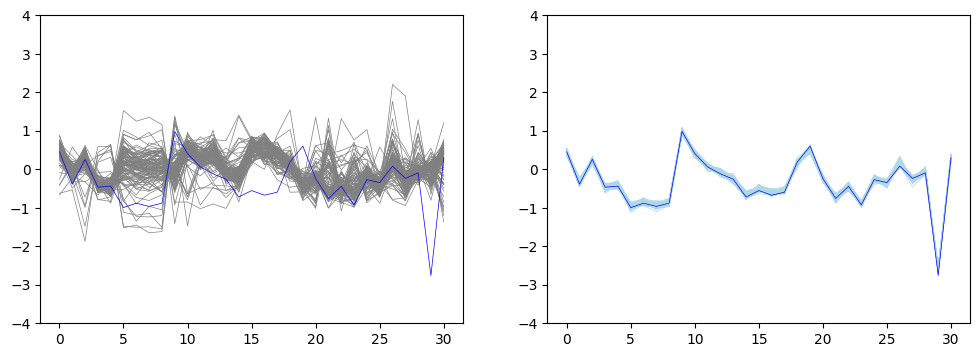

In [13]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
for sample1, sample2 in zip(samples, samples2):
    ax[0].plot(sample1, 'gray', linewidth=0.5)
    ax[1].plot(sample2, 'lightblue', linewidth=0.5)
ax[0].plot(validation_params, 'blue', linewidth=0.5)
ax[1].plot(validation_params, 'blue', linewidth=0.5)

# np.savetxt('tikz/fig_conditional_data/params.csv',      X=np.vstack([np.arange(31),samples   ]).T, delimiter=' ', header=header, comments='')
# np.savetxt('tikz/fig_conditional_data/params_cond.csv', X=np.vstack([np.arange(31),samples2  ]).T, delimiter=' ', header=header, comments='')
# np.savetxt('tikz/fig_conditional_data/params_y.csv',    X=np.vstack([np.arange(31),samples[i]]).T)

ylim = [-4,4]
ax[0].set(ylim=ylim)
ax[1].set(ylim=ylim)

#### Conditioning on the observed stress

35


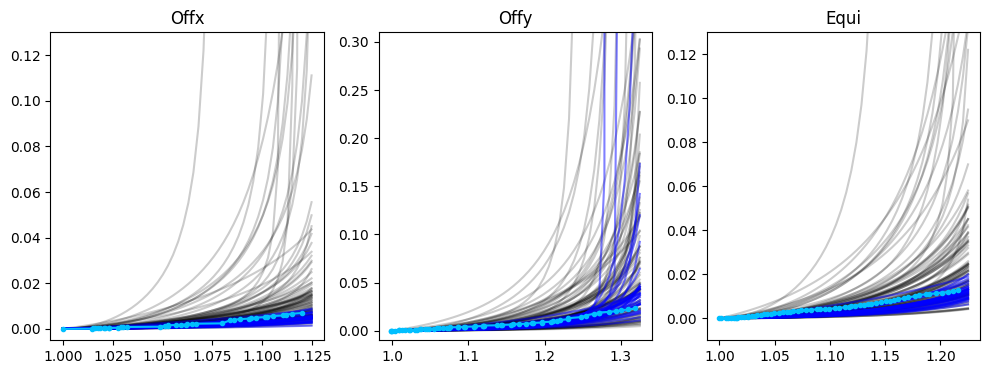

In [27]:
score_model = ApproximateScore()
trained_score = lambda x, t: score_model.apply(params_diff, x, t)
rng, step_rng = random.split(rng)
n_params = 31
samples = reverse_sde(step_rng, n_params, 100, drift, dispersion, trained_score)
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

lmby_offx = np.linspace(1,1.265) 
lmbx_offx = np.sqrt(lmby_offx)
lmbx_offy = np.linspace(1,1.325) 
lmby_offy = np.sqrt(lmbx_offy)
lmbx_equi = np.linspace(1,1.225)
lmby_equi = lmbx_equi

offx_stress = [lmbx_offx]
offy_stress = [lmbx_offy]
equi_stress = [lmbx_equi]
header = 'x'
for i, l in enumerate(samples):
    offx, offy, equi = plot_offx_offy_equi_pred(ax, l, 'k', 0.2)
    offx_stress.append(offx)
    offy_stress.append(offy)
    equi_stress.append(equi)
    header = header + ' y' + str(i)
ax[0].set(ylim=[-0.005, 0.13], title='Offx')
ax[1].set(ylim=[ -0.01, 0.31], title='Offy')
ax[2].set(ylim=[ -0.01, 0.13], title='Equi')
np.savetxt('tikz/fig_conditional_2_data/offx_stress.csv', np.array(offx_stress).T, header = header, comments = '')
np.savetxt('tikz/fig_conditional_2_data/offy_stress.csv', np.array(offy_stress).T, header = header, comments = '')
np.savetxt('tikz/fig_conditional_2_data/equi_stress.csv', np.array(equi_stress).T, header = header, comments = '')


# Condition on observed stresses
lmbx, lmby, sgmx_gt, sgmy_gt = murine_data[murine_data.ID==15][['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy().T
lmbx = lmbx[::10]
lmby = lmby[::10]
sgmx_gt = sgmx_gt[::10]
sgmy_gt = sgmy_gt[::10]
sgm_measure = 0.01
def stress_log_likelihood(x):
    x_unscaled = x*std_x+mu_x 
    sample_params = unravel_params(x_unscaled)
    
    params = merge_weights_aniso(params_all, sample_params)
    mymodel = NODE_model_aniso(params, normalization)
    sgmx_pr, sgmy_pr = eval_Cauchy_aniso_vmap(lmbx,lmby, mymodel)
    return jnp.sum(-(sgmx_gt - sgmx_pr)**2/sgm_measure**2) + jnp.sum(-(sgmy_gt - sgmy_pr)**2/sgm_measure**2)

stress_score = vmap(grad(stress_log_likelihood), in_axes=(0,))
def mod_score_2(x, t):
    return trained_score(x,t) + stress_score(x)


samples2 = reverse_sde(step_rng, n_params, 100, drift, dispersion, mod_score_2)
offx_stress_cond = [lmbx_offx]
offy_stress_cond = [lmbx_offy]
equi_stress_cond = [lmbx_equi]
header = 'x'
j = 0
for i, l in enumerate(samples2):
    offx, offy, equi = plot_offx_offy_equi_pred(ax, l, 'b', 0.5)
    if not any(np.isnan(offx)):
        offx_stress_cond.append(np.clip(offx, a_min=0, a_max=1000))
        offy_stress_cond.append(np.clip(offy, a_min=0, a_max=1000))
        equi_stress_cond.append(np.clip(equi, a_min=0, a_max=1000))
        header = header + ' y' + str(j)
        j+= 1
print(len(offx_stress_cond))
np.savetxt('tikz/fig_conditional_2_data/offx_stress_cond.csv', np.array(offx_stress_cond).T, header = header, comments = '')
np.savetxt('tikz/fig_conditional_2_data/offy_stress_cond.csv', np.array(offy_stress_cond).T, header = header, comments = '')
np.savetxt('tikz/fig_conditional_2_data/equi_stress_cond.csv', np.array(equi_stress_cond).T, header = header, comments = '')

labels = ['offx', 'offy', 'equi']
for t, label in enumerate(labels):
    lmbx, lmby, sgmx_gt, sgmy_gt = murine_data[(murine_data.ID==15)&(murine_data.test==t)][['lm11', 'lm22', 'sigma11 (MPa)', 'sigma22 (MPa)']].to_numpy().T
    ax[t].plot(lmbx,sgmx_gt, color='deepskyblue', marker='.')
    np.savetxt('tikz/fig_conditional_2_data/' + label + '_stress_gt.csv', np.array([lmbx, sgmx_gt*1000]).T)

34


[(-4.0, 4.0)]

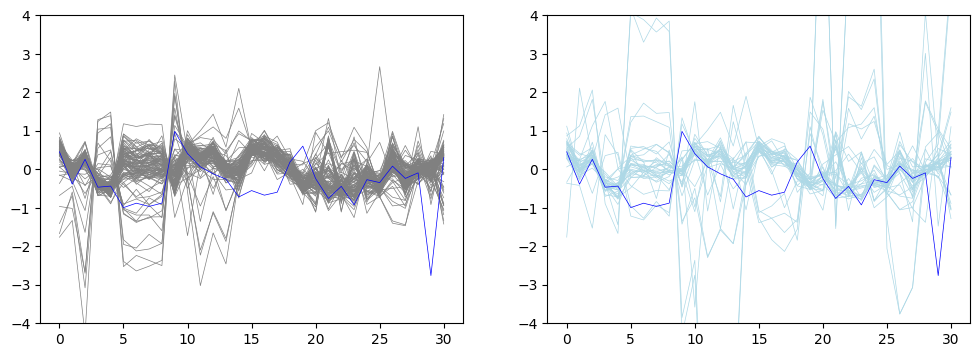

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
for sample1, sample2 in zip(samples, samples2):
    ax[0].plot(sample1, 'gray', linewidth=0.5)
    ax[1].plot(sample2, 'lightblue', linewidth=0.5)
ax[0].plot(validation_params, 'blue', linewidth=0.5)
ax[1].plot(validation_params, 'blue', linewidth=0.5)

np.savetxt('tikz/fig_conditional_2_data/params.csv',      X=np.vstack([np.arange(31),samples   ]).T, delimiter=' ', header=header, comments='')
samples3 = []
for l in samples2:
    if not any(np.isnan(l)):
        samples3.append(l)
print(len(samples3))
np.savetxt('tikz/fig_conditional_2_data/params_cond.csv', X=np.vstack([np.arange(31),samples3  ]).T, delimiter=' ', header=header, comments='')
np.savetxt('tikz/fig_conditional_2_data/params_y.csv',    X=np.vstack([np.arange(31),samples[i]]).T)

ylim = [-4,4]
ax[0].set(ylim=ylim)
ax[1].set(ylim=ylim)